In [62]:
import tensorflow as tf
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
import tensorflow_hub as hub
import tensorflow_text as text
import json
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [63]:
# Import dataset with Pandas 
dataset = pd.read_csv("src/spam.csv", encoding="ISO-8859-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# 1/ EDA

In [64]:
dataset.describe(include='all') # only 5572 rows which is very small for deep learning

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [65]:
# the unnamed columns contain some information, I chose to put them at the end of the 'v2' column
dataset['SMS'] = dataset['v2'].fillna('') + dataset['Unnamed: 2'].fillna('') + dataset['Unnamed: 3'].fillna('') + dataset['Unnamed: 4'].fillna('')

In [66]:
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,SMS
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro..."


In [67]:
dataset.drop(['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
dataset.rename({'v1': 'target'}, axis=1, inplace=True)
dataset['target_num'] = dataset['target'].apply(lambda x: 0 if x=='ham' else 1) # creating 0 and 1 column to categorize the SMS with sigmoid function later on
dataset.head()

,target,SMS,target_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [68]:
pie = dataset['target'].value_counts()
pie

ham     4825
spam     747
Name: target, dtype: int64

In [69]:
# Let's have a look at the repartition between ham and spam
colors = ['mediumturquoise', 'darkorange']

fig = go.Figure()
fig.add_trace(go.Pie(labels = ['ham', 'spam'], values = [pie[0], pie[1]]))
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=1)))
fig.show()

The dataset is very imbalanced, with only 13.4% of spams. It is quite logical though.

# 2/ Preprocessing

In [70]:
!python3 -m spacy download en_core_web_sm

2023-01-31 09:32:59.010402: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 09:32:59.108058: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-31 09:32:59.110551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 09:32:59.110570: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [71]:
# Import Spacy and english initialisation
import en_core_web_sm
nlp = en_core_web_sm.load()

In [72]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [73]:
dataset["SMS_clean"] = dataset["SMS"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" ")) # keep only aphanumeric characters and whitespaces
dataset["SMS_clean"] = dataset["SMS_clean"].apply(lambda x: x.replace(" +"," ").lower().strip()) # remove double spaces and spaces at the beginning and end of strings, and lower all the words
dataset["SMS_clean"] = dataset["SMS_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)])) # remove all stop words and replace every word with its lemma

dataset

,target,SMS,target_num,SMS_clean
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,2nd time try 2 contact u u win å750 pound priz...
5568,ham,Will Ì_ b going to esplanade fr home?,0,ì b esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",0,pity mood soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,0,guy bitching act like d interested buy week free


In [74]:
# Using the tokenizer process for encoding all the SMS
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) # instanciate the tokenizer
tokenizer.fit_on_texts(dataset['SMS_clean'])
dataset["SMS_encoded"] = tokenizer.texts_to_sequences(dataset['SMS_clean'])
dataset["len_SMS"] = dataset["SMS_encoded"].apply(lambda x: len(x))
dataset = dataset[dataset["len_SMS"]!=0] # remove empty SMS if text preprocessing removed everything

dataset

,target,SMS,target_num,SMS_clean,SMS_encoded,len_SMS
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis n great wor...,"[3621, 233, 448, 463, 943, 35, 52, 205, 944, 7...",14
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif u oni,"[10, 194, 464, 289, 1, 1460]",6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry 2 wkly comp win fa cup final tkts 2...,"[12, 298, 3, 535, 667, 33, 1461, 856, 424, 146...",22
3,ham,U dun say so early hor... U c already then say...,0,u dun early hor u c,"[1, 125, 150, 2362, 1, 85]",6
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live,"[712, 22, 668, 129]",4
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,2nd time try 2 contact u u win å750 pound priz...,"[265, 18, 48, 3, 92, 1, 1, 33, 8295, 278, 69, ...",19
5568,ham,Will Ì_ b going to esplanade fr home?,0,ì b esplanade fr home,"[45, 108, 1543, 578, 26]",5
5569,ham,"Pity, * was in mood for that. So...any other s...",0,pity mood soany suggestion,"[8298, 939, 8299, 3617]",4
5570,ham,The guy did some bitching but I acted like i'd...,0,guy bitching act like d interested buy week free,"[113, 8300, 1351, 14, 30, 995, 87, 39, 12]",9


In [75]:
# dataset.to_csv("src/spam_clean.csv")

In [76]:
# Padding the SMS in order to have the same length for all of them. It is needed to create a tensor dataset
SMS_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset["SMS_encoded"], padding="post")

In [77]:
# separate in train and test datasets
X_train, X_test, y_train, y_test = train_test_split(SMS_pad, dataset['target_num'], test_size=0.3, random_state=42, stratify = dataset['target_num'])

In [78]:
# Creating the tensor datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [79]:
# Creating batches of length 64
train_ds = train_ds.shuffle(len(train_ds)).batch(64)
test_ds = test_ds.shuffle(len(test_ds)).batch(64)

Let's have a look at one batch

In [80]:
for SMS, target in train_ds.take(1):
  print(SMS, target)

tf.Tensor(
[[  15 7368  528 ...    0    0    0]
 [  41  546   46 ...    0    0    0]
 [ 962    0    0 ...    0    0    0]
 ...
 [ 183   33   90 ...    0    0    0]
 [  31  246  150 ...    0    0    0]
 [3797  426 1851 ...    0    0    0]], shape=(64, 72), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0], shape=(64,), dtype=int64)


The first tensor is of shape (64, 72) : 64 for the length of the batch and 72 for the length of the SMS tokenized and padded.  
The second tensor is the target (0 or 1) for each of the 64 SMS.

# 3/ Deep learning models from scratch  
## Simple RNN model

In [81]:
vocab_size = len(tokenizer.word_index)
vocab_size

8300

In [82]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path_RNN = "trainingRNN/cp-{epoch:04d}.ckpt" # the path where checkpoint files will be stored

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_RNN, 
    verbose=1,
    save_weights_only=True,
    save_freq=1*len(train_ds))

In [83]:
model_RNN = tf.keras.Sequential([
                  # Word Embedding layer (we use vocab size + 1 because of the padding that need to be embedded as well)           
                  Embedding(vocab_size+1, 64, input_shape=[SMS.shape[1],],name="embedding"),
                  # Simple RNN layers
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  tf.keras.layers.BatchNormalization(), # necessary in that case otherwise the model does not train
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with one neuron and sigmoid activation function because we need 0 or 1 as an output
                  Dense(1, activation="sigmoid")
])

# Save the weights using the `checkpoint_path` format
model_RNN.save_weights(checkpoint_path_RNN.format(epoch=0))

In [84]:
model_RNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 64)            531264    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 72, 64)            8256      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                      

The number of trainable parameters is high : 543 361 for only 5 572 rows.

In [85]:
model_RNN.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(), # metrics adapted to binary classification
              metrics=['binary_accuracy']) # metrics adapted to binary classification

In [86]:
dataset['target_num'].value_counts()

0    4808
1     747
Name: target_num, dtype: int64

In [87]:
# Define weights equal to the inverse of frequency for the target (ham or spam)
weights = 1/(dataset['target_num']).value_counts()
weights = weights * len(dataset)/2
weights = {index : values for index , values in zip(weights.index,weights.values)}
weights

{0: 0.5776830282861897, 1: 3.718206157965194}

In [88]:
# Model training with weights to penalize too frequent hams
model_RNN.fit(train_ds,
          epochs=20, 
          validation_data=test_ds,
          callbacks=[cp_callback],
          class_weight=weights
          )

Epoch 1/20
59/61 [============================>.] - ETA: 0s - loss: 0.4195 - binary_accuracy: 0.7770
Epoch 1: saving model to trainingRNN/cp-0001.ckpt
61/61 [==============================] - 4s 40ms/step - loss: 0.4152 - binary_accuracy: 0.7783 - val_loss: 0.2994 - val_binary_accuracy: 0.9100
Epoch 2/20
60/61 [============================>.] - ETA: 0s - loss: 0.1854 - binary_accuracy: 0.9393
Epoch 2: saving model to trainingRNN/cp-0002.ckpt
61/61 [==============================] - 2s 36ms/step - loss: 0.1856 - binary_accuracy: 0.9396 - val_loss: 0.1129 - val_binary_accuracy: 0.9718
Epoch 3/20
59/61 [============================>.] - ETA: 0s - loss: 0.1110 - binary_accuracy: 0.9582
Epoch 3: saving model to trainingRNN/cp-0003.ckpt
61/61 [==============================] - 2s 37ms/step - loss: 0.1084 - binary_accuracy: 0.9594 - val_loss: 0.1833 - val_binary_accuracy: 0.9496
Epoch 4/20
59/61 [============================>.] - ETA: 0s - loss: 0.0364 - binary_accuracy: 0.9897
Epoch 4: savin

In [89]:
# model_RNN.save("content/model_simpleRNN.h5")

In [90]:
# json.dump(model_RNN.history.history, open("content/simpleRNN_history.json", 'w'))

In [91]:
simpleRNN_history = json.load(open("content/simpleRNN_history.json", 'r'))

In [92]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=simpleRNN_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=simpleRNN_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [93]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=simpleRNN_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy'))
fig.add_trace(go.Scatter(y=simpleRNN_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy'))
fig.show()

We can observe that the model trains well on the test set but overfitting happens after 2 epochs, and the model is not valid anymore after 7 epochs.

## GRU

In [94]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path_GRU = "trainingGRU/cp-{epoch:04d}.ckpt" # the path where checkpoint files will be stored

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_GRU, 
    verbose=1,
    save_weights_only=True,
    save_freq=1*len(train_ds))

In [95]:
model_GRU = tf.keras.Sequential([
                  # Word Embedding layer (we use vocab size + 1 because of the padding that need to be embedded as well)           
                  Embedding(vocab_size+1, 64, input_shape=[SMS.shape[1],],name="embedding"),
                  # GRU layers
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=32, return_sequences=False), # returns the last output
                  tf.keras.layers.BatchNormalization(), # necessary in that case otherwise the model does not train
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with one neuron and sigmoid activation function because we need 0 or 1 as an output
                  Dense(1, activation="sigmoid")
])

# Save the weights using the `checkpoint_path` format
model_GRU.save_weights(checkpoint_path_GRU.format(epoch=0))

In [96]:
model_GRU.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 64)            531264    
                                                                 
 gru_2 (GRU)                 (None, 72, 64)            24960     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                      

In [97]:
model_GRU.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])

In [98]:
model_GRU.fit(train_ds,
          epochs=20, 
          validation_data=test_ds,
          callbacks=[cp_callback],
          class_weight=weights
          )

Epoch 1/20
60/61 [============================>.] - ETA: 0s - loss: 0.6925 - binary_accuracy: 0.1458
Epoch 1: saving model to trainingGRU/cp-0001.ckpt
61/61 [==============================] - 8s 93ms/step - loss: 0.6933 - binary_accuracy: 0.1461 - val_loss: 0.7055 - val_binary_accuracy: 0.1344
Epoch 2/20
60/61 [============================>.] - ETA: 0s - loss: 0.6928 - binary_accuracy: 0.3521
Epoch 2: saving model to trainingGRU/cp-0002.ckpt
61/61 [==============================] - 5s 87ms/step - loss: 0.6932 - binary_accuracy: 0.3495 - val_loss: 0.6422 - val_binary_accuracy: 0.8656
Epoch 3/20
60/61 [============================>.] - ETA: 0s - loss: 0.6930 - binary_accuracy: 0.5990
Epoch 3: saving model to trainingGRU/cp-0003.ckpt
61/61 [==============================] - 5s 84ms/step - loss: 0.6933 - binary_accuracy: 0.6021 - val_loss: 0.6132 - val_binary_accuracy: 0.8656
Epoch 4/20
60/61 [============================>.] - ETA: 0s - loss: 0.5128 - binary_accuracy: 0.8313
Epoch 4: savin

In [99]:
# model_GRU.save("content/model_GRU.h5")

In [100]:
# json.dump(model_GRU.history.history, open("content/GRU_history.json", 'w'))

In [101]:
GRU_history = json.load(open("content/GRU_history.json", 'r'))

In [102]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=GRU_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [103]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=GRU_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy'))
fig.add_trace(go.Scatter(y=GRU_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy'))
fig.show()

The GRU model has finished to train after 7 epochs and there is some overfitting.

# LSTM

In [104]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path_LSTM = "trainingLSTM/cp-{epoch:04d}.ckpt" # the path where checkpoint files will be stored

# Create a callback that saves the model's weights every epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_LSTM, 
    verbose=1,
    save_weights_only=True,
    save_freq=1*len(train_ds))

In [105]:
model_LSTM = tf.keras.Sequential([
                  # Word Embedding layer (we use vocab size + 1 because of the padding that need to be embedded as well)           
                  Embedding(vocab_size+1, 64, input_shape=[SMS.shape[1],],name="embedding"),
                  # LSTM layers
                  LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=32, return_sequences=False), # returns the last output
                  tf.keras.layers.BatchNormalization(), # necessary in that case otherwise the model does not train
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with one neuron and sigmoid activation function because we need 0 or 1 as an output
                  Dense(1, activation="sigmoid")
])

# Save the weights using the `checkpoint_path` format
model_LSTM.save_weights(checkpoint_path_LSTM.format(epoch=0))

In [106]:
model_LSTM.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 64)            531264    
                                                                 
 lstm_2 (LSTM)               (None, 72, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dense_16 (Dense)            (None, 8)                 136       
                                                      

In [107]:
model_LSTM.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy'])

In [108]:
model_LSTM.fit(train_ds,
          epochs=20, 
          validation_data=test_ds,
          callbacks=[cp_callback],
          class_weight=weights
          )

Epoch 1/20
59/61 [============================>.] - ETA: 0s - loss: 0.5104 - binary_accuracy: 0.8159
Epoch 1: saving model to trainingLSTM/cp-0001.ckpt
61/61 [==============================] - 7s 83ms/step - loss: 0.5026 - binary_accuracy: 0.8197 - val_loss: 0.3143 - val_binary_accuracy: 0.9430
Epoch 2/20
60/61 [============================>.] - ETA: 0s - loss: 0.1216 - binary_accuracy: 0.9794
Epoch 2: saving model to trainingLSTM/cp-0002.ckpt
61/61 [==============================] - 5s 74ms/step - loss: 0.1216 - binary_accuracy: 0.9794 - val_loss: 0.4516 - val_binary_accuracy: 0.9352
Epoch 3/20
59/61 [============================>.] - ETA: 0s - loss: 0.0552 - binary_accuracy: 0.9926
Epoch 3: saving model to trainingLSTM/cp-0003.ckpt
61/61 [==============================] - 4s 68ms/step - loss: 0.0546 - binary_accuracy: 0.9925 - val_loss: 0.2824 - val_binary_accuracy: 0.8908
Epoch 4/20
60/61 [============================>.] - ETA: 0s - loss: 0.0369 - binary_accuracy: 0.9922
Epoch 4: sa

In [109]:
# model_LSTM.save("content/model_LSTM.h5")

In [110]:
# json.dump(model_LSTM.history.history, open("content/LSTM_history.json", 'w'))

In [111]:
LSTM_history = json.load(open("content/LSTM_history.json", 'r'))

In [112]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["loss"],
                    mode='lines',
                    name='loss'))
fig.add_trace(go.Scatter(y=LSTM_history["val_loss"],
                    mode='lines',
                    name='val_loss'))
fig.show()

In [113]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=LSTM_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy'))
fig.add_trace(go.Scatter(y=LSTM_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy'))
fig.show()

The LSTM model trains well but overfits happens quickly after 3 epochs.

## View all the results

In [114]:
# Compare simple RNN, GRU and LSTM
fig = go.Figure()
fig.add_trace(go.Scatter(y=simpleRNN_history["loss"],
                    mode='lines',
                    name='loss_RNN',
                    marker_color = 'darkblue'))
fig.add_trace(go.Scatter(y=simpleRNN_history["val_loss"],
                    mode='lines',
                    name='val_loss_RNN',
                    marker_color = 'cornflowerblue'))
fig.add_trace(go.Scatter(y=GRU_history["loss"],
                    mode='lines',
                    name='loss_GRU',
                    marker_color = 'darkgreen'))
fig.add_trace(go.Scatter(y=GRU_history["val_loss"],
                    mode='lines',
                    name='val_loss_GRU',
                    marker_color = 'limegreen'))
fig.add_trace(go.Scatter(y=LSTM_history["loss"],
                    mode='lines',
                    name='loss_LSTM',
                    marker_color = 'darkred'))
fig.add_trace(go.Scatter(y=LSTM_history["val_loss"],
                    mode='lines',
                    name='val_loss_LSTM',
                    marker_color = 'tomato'))
fig.update_layout(title='Loss for Simple RNN, GRU and LSTM', title_x = 0.5,
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

In [115]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=simpleRNN_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy_RNN',
                    marker_color = 'darkblue'))
fig.add_trace(go.Scatter(y=simpleRNN_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy_RNN',
                    marker_color = 'cornflowerblue'))
fig.add_trace(go.Scatter(y=GRU_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy_GRU',
                    marker_color = 'darkgreen'))
fig.add_trace(go.Scatter(y=GRU_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy_GRU',
                    marker_color = 'limegreen'))
fig.add_trace(go.Scatter(y=LSTM_history["binary_accuracy"],
                    mode='lines',
                    name='binary_accuracy_LSTM',
                    marker_color = 'darkred'))
fig.add_trace(go.Scatter(y=LSTM_history["val_binary_accuracy"],
                    mode='lines',
                    name='val_binary_accuracy_LSTM',
                    marker_color = 'tomato'))
fig.update_layout(title='Accuracy for Simple RNN, GRU and LSTM', title_x = 0.5,
                  yaxis_zeroline=False, xaxis_zeroline=False)
fig.show()

The GRU model offers the best performances (lowest validation loss and highest validation accuracy).

In [116]:
# Loading GRU model at checkpoint 10 epochs
model_GRU.load_weights("trainingGRU/cp-0010.ckpt")

In [117]:
pred_train = model_GRU.predict(X_train)
pred_test = model_GRU.predict(X_test)

53/53 [==============================] - 1s 26ms/step


In [118]:
pred_test

array([[6.7607718e-05],
       [6.4312306e-05],
       [8.7717206e-05],
       ...,
       [4.9886832e-05],
       [5.9758429e-05],
       [9.9997222e-01]], dtype=float32)

In [119]:
# convert the output of sigmoid function into 0 or 1
y_train_pred = tf.cast(tf.greater(pred_train, 0.5), tf.int32)
y_test_pred = tf.cast(tf.greater(pred_test, 0.5), tf.int32)

In [120]:
y_test_pred

<tf.Tensor: shape=(1667, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]], dtype=int32)>

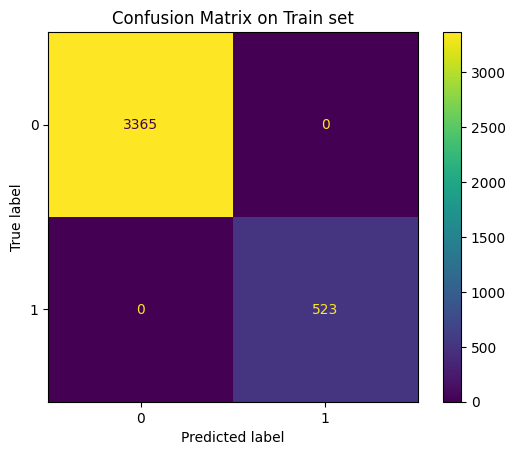

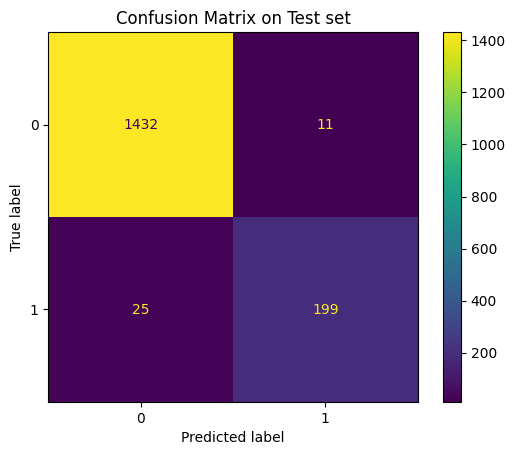

In [121]:
# Visualize confusion matrices for the GRU model
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=ax)

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") 
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=ax)
plt.show()

In [122]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1443
           1       0.95      0.89      0.92       224

    accuracy                           0.98      1667
   macro avg       0.97      0.94      0.95      1667
weighted avg       0.98      0.98      0.98      1667



In [ ]:
# conclusion